In [67]:
import os
from dotenv import load_dotenv

# from datetime import datetime, timedelta
import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import numpy as np
# from functions import util

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
load_dotenv()
os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()

fs = project.get_feature_store() 

2024-12-24 10:44:19,961 INFO: Initializing external client
2024-12-24 10:44:19,961 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-24 10:44:21,575 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164448


In [3]:
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)

# Step 3: Read the data from the feature group
solana_df = solana_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
solana_df['open_diff'] = solana_df['open'].diff().fillna(0)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


In [4]:
# Step 2: Retrieve the feature group by name and version
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Step 3: Read the data from the feature group
bitcoin_df = bitcoin_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
bitcoin_df['open_diff'] = bitcoin_df['open'].diff()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


In [5]:
fs = project.get_feature_store(name='kth_lab1_2024_featurestore')
fng_feature_group = fs.get_feature_group('f_n_g_index', version=6)
fng_df = fng_feature_group.read()
fng_df['timestamp'] = fng_df['date'].astype('int64')/ 10**6 # Convert nanoseconds to seconds
fng_df = fng_df.sort_values(by='timestamp', inplace=False).reset_index(drop=True)
fng_df.drop(columns=["date"], inplace=True)
fng_labels_to_numbers_map={"Extreme Fear":0, "Fear":1, "Neutral":2, "Greed":3, "Extreme Greed":4} 
fng_numbers_to_labels_map={0:"Extreme Fear", 1:"Fear", 2:"Neutral", 3:"Greed", 4:"Extreme Greed"} 

fng_df['fng_classification'] = fng_df['fng_classification'].replace(fng_labels_to_numbers_map)
fng_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,fng_value,fng_classification,timestamp
0,30,1,1.517443e+09
1,15,0,1.517530e+09
2,40,1,1.517616e+09
3,24,0,1.517702e+09
4,11,0,1.517789e+09
...,...,...,...
2509,75,3,1.734566e+09
2510,74,3,1.734653e+09
2511,73,3,1.734739e+09
2512,73,3,1.734826e+09


In [8]:

all_data = pd.merge(solana_df, bitcoin_df, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_df, how='inner', on="timestamp")

# target = all_data["open_solana"]
# all_data = all_data.drop(["open_solana"], axis=1, inplace=False)
all_data


,timestamp,open_solana,high_solana,low_solana,close_solana,volume_solana,volume_buy_solana,volume_sell_solana,open_diff_solana,open_bitcoin,high_bitcoin,low_bitcoin,close_bitcoin,volume_bitcoin,volume_buy_bitcoin,volume_sell_bitcoin,open_diff_bitcoin,fng_value,fng_classification
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,0.00,38337.1,39561.4,37405.0,38078.2,6003.220618,2954.239333,3048.981285,-1829.5,26,1
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,-1.10,38078.2,38193.1,35126.0,35824.0,6558.468890,2951.829138,3606.639753,-258.9,25,0
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,-2.51,35824.0,36450.0,34901.0,35490.5,4485.076656,2163.692566,2321.384090,-2254.2,23,0
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,-1.17,35490.5,36112.2,33370.0,35595.0,6286.306438,3200.202119,3086.104319,-333.5,21,0
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,-0.17,35595.0,35750.8,31260.0,31655.2,11395.959899,5305.991000,6089.968899,104.5,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1734566400,206.49,215.00,186.80,193.65,452547.729871,185623.785796,266923.944075,-16.74,100166.1,102750.0,95586.4,97431.4,3582.993384,1634.942176,1948.051208,-5985.8,75,3
1281,1734652800,193.65,199.44,175.01,194.40,463451.482080,210245.812667,253205.669413,-12.84,97431.4,98064.7,92159.0,97781.8,3145.577624,1246.352081,1899.225543,-2734.7,74,3
1282,1734739200,194.40,201.91,178.50,181.06,308103.063575,122417.224892,185685.838684,0.75,97781.8,99575.4,96359.8,97232.6,1158.063596,550.601852,607.461744,350.4,73,3
1283,1734825600,181.06,187.86,176.87,180.34,218352.282441,108511.764430,109840.518011,-13.34,97232.6,97321.3,94201.1,95101.9,843.506407,277.687032,565.819376,-549.2,73,3


In [13]:
# all_data = all_data.drop(columns=['timestamp'])
columns = [col for col in all_data.columns if col != 'open_solana']  # List all columns except 'open_solana'
columns.append('open_solana')  # Add 'open_solana' at the end
all_data = all_data[columns] 

scaler = MinMaxScaler(feature_range=(0, 1))
all_data_scaled = scaler.fit_transform(all_data)

# X = all_data.drop(columns=['open_solana'])  # All features except the target
# y = all_data['open_solana'] 

In [21]:
all_data.shape

(1285, 18)

In [ ]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        row = data[i:i+time_steps, :-1]
        X.append(row)  # Features for the previous 10 time steps
        y.append(data[i+time_steps, -1])  
    return np.array(X), np.array(y)

X, y = create_sequences(all_data_scaled, time_steps=10)

In [26]:
# Split data into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")


X_train shape: (892, 10, 17), X_val shape: (191, 10, 17), X_test shape: (192, 10, 17)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((10, 17)))
model1.add(LSTM(16, return_sequences=False))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 16)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,321 (9.07 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [39]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp1])

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5648e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0160e-04 - root_mean_squared_error: 0.0200 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1514e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7220e-04 - root_mean_squared_error: 0.0192 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3783e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3205e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 7/1000
28/28 ━━━━━━━━━

In [40]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/best_model.keras')
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,0.080616,0.079305
1,0.084046,0.088821
2,0.089227,0.093760
3,0.094998,0.096972
4,0.095551,0.105204
...,...,...
887,0.192435,0.199245
888,0.199968,0.201494
889,0.212816,0.217274
890,0.216941,0.214223


In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test})

mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

res_dict = { 
        "MSE": str(mse),
        "R squared": str(rmse),
    }
# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 0.0001384996447554203
Root Mean Squared Error (RMSE): 0.011768587203034198


In [49]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(y_predicted, y_actual, start=0, end=100):
  df = pd.DataFrame(data={'Predictions': y_predicted, 'Actuals':y_actual})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return 

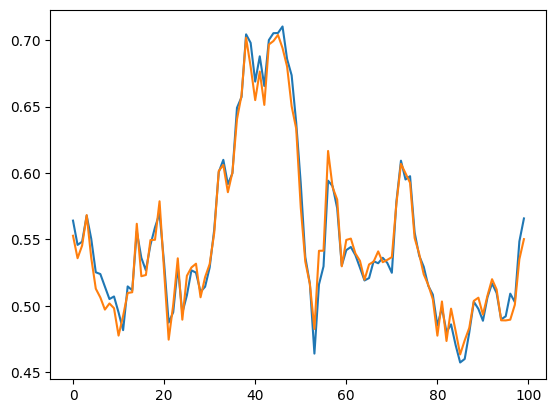

In [50]:
plot_predictions(test_predictions, y_test)

## Save model on registry

In [51]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [ ]:
mr = project.get_model_registry()


# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()


sample_indices = np.random.choice(X_test.shape[0], size=17, replace=False)
sample_test_values = X_test[sample_indices]

solana_model_1 = mr.python.create_model(
    name="solana_price_daily_model_1", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=sample_test_values, 
    description="Solana daily price predictor",
)

model_dir = "solana_price_daily_model_1"

solana_model_1.save(model_dir)

Uploading model files (0 dirs, 0 files):  17%|█▋        | 1/6 [00:01<00:05,  1.15s/it]


OSError: Could not find path solana_price_daily_model_1 in the local filesystem or in Hopsworks File System

In [64]:
res_dict

{'MSE': '<function mean_squared_error at 0x15aeed900>',
 'R squared': '0.011768587203034198'}

In [56]:
X_test.shape

(192, 10, 17)